# 不要随意修改此版本

当自己所负责的模块调试无误后，请将代码复制到此处

建议每个人在自己的文件夹下重新建立一个文件来运行文件或调参

不要多人在本文件修改

如要修改请提前在微信群向大家说明

# 导入库（如果没有你需要的，请在这里import并重新运行）

In [1]:
import os
import time 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm
from lightgbm import Dataset
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import ExtraTreesRegressor as etr
from sklearn.linear_model import BayesianRidge as br
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import ElasticNet as en
from sklearn.kernel_ridge import KernelRidge as kr
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LassoCV,Lasso
import logging
from numpy import int64,float64
import warnings
warnings.filterwarnings('ignore') #消除warning

# 读取数据

In [2]:
data = pd.read_csv('data.csv')
data.head()

,SAMPLE_ID,TYPE,Unnamed: 0,A1BG,A2M,NAT1,NAT2,SERPINA3,AADAC,AAMP,...,LOC100289341,ZNF605,NHEG1,LOC100302401,LOC100302640,LOC100302650,NCRNA00182,TMED7-TICAM2,TSNAX-DISC1,LOC100303728
0,HCCDB-15.S1,HCC,HCCDB-15.S1,15.57,16.20,6.29,6.76,16.53,11.38,10.49,...,4.76,7.62,2.30,2.92,0.00,5.51,3.68,4.06,0.00,5.59
1,HCCDB-15.S2,HCC,HCCDB-15.S2,8.61,11.66,5.12,1.72,11.52,11.01,11.10,...,4.31,9.15,0.82,2.98,1.34,2.76,3.93,6.83,1.21,5.06
2,HCCDB-15.S3,HCC,HCCDB-15.S3,12.77,16.34,6.67,5.22,14.39,11.97,10.55,...,4.07,9.15,0.00,4.18,0.75,2.54,4.13,5.83,0.00,4.43
3,HCCDB-15.S4,HCC,HCCDB-15.S4,14.76,17.96,6.72,7.31,15.03,11.97,11.27,...,4.97,9.12,0.00,3.58,0.88,3.23,2.60,5.93,0.00,3.36
4,HCCDB-15.S5,HCC,HCCDB-15.S5,12.83,14.38,7.81,7.23,14.59,12.29,11.06,...,3.66,8.95,0.00,3.52,0.00,2.16,2.99,4.96,0.00,5.51


In [3]:
print(data.TYPE.value_counts(),data.columns)

HCC         351
Adjacent     49
Name: TYPE, dtype: int64 Index(['SAMPLE_ID', 'TYPE', 'Unnamed: 0', 'A1BG', 'A2M', 'NAT1', 'NAT2',
       'SERPINA3', 'AADAC', 'AAMP',
       ...
       'LOC100289341', 'ZNF605', 'NHEG1', 'LOC100302401', 'LOC100302640',
       'LOC100302650', 'NCRNA00182', 'TMED7-TICAM2', 'TSNAX-DISC1',
       'LOC100303728'],
      dtype='object', length=20533)


##### 数据属性过多，并且样本不平衡（7:1）

## lasso回归筛选特征

In [4]:
data['TYPE'] = data['TYPE'].replace(['HCC','Adjacent'],[0,1])       #label需要变成数值形式
X = data.drop(['TYPE','Unnamed: 0','SAMPLE_ID'],axis=1)
y = data['TYPE']
colNames = X.columns
x = StandardScaler().fit_transform(X)    #数据标准化
x = pd.DataFrame(x)
x.columns = colNames   #x为标准化后的数据

In [5]:
alphas = np.logspace(-3,1,50)   #主要参数
model_lassoCV = LassoCV(alphas = alphas,cv=20,max_iter=1000).fit(x,y)
print(model_lassoCV.alpha_)

0.006551285568595509


In [6]:
coef = pd.Series(model_lassoCV.coef_,index=x.columns)
#print(coef)
print('Lasso picked'+str(sum(coef != 0))+'variables and eliminated the other'+str(sum(coef == 0)))

Lasso picked178variables and eliminated the other20352


In [7]:
index = coef[coef !=0].index
x_lasso = x[index]
x_lasso.head()
print(coef[coef != 0 ])

ACCN1          -0.004943
ADCYAP1R1       0.004223
ADRA2B          0.014669
AMPD1           0.001199
CACNA1F        -0.001448
                  ...   
RSPH10B2        0.009377
LOC729467      -0.008201
HAR1B           0.000110
SNORD115-26    -0.000609
LOC100128239   -0.000451
Length: 178, dtype: float64


In [8]:
x_lasso.head()

,ACCN1,ADCYAP1R1,ADRA2B,AMPD1,CACNA1F,CAV3,CDH13,CETP,CHGB,COL9A1,...,SEPT7P2,RASSF10,C3orf71,KRTAP4-11,SNORA2B,RSPH10B2,LOC729467,HAR1B,SNORD115-26,LOC100128239
0,-0.864651,-0.492451,0.393377,1.030848,0.747743,-0.34809,-0.564598,0.179101,-0.681029,-0.054536,...,-0.629717,-0.474576,0.719180,-0.086808,-0.111814,-1.258098,2.907696,-0.870011,-0.558482,-0.799377
1,-0.864651,1.859704,-2.016857,-0.654214,0.474686,-0.34809,-0.111984,-1.842604,0.592663,-0.781474,...,0.238571,4.526964,-1.712514,-0.086808,-0.111814,-0.809774,-0.386295,-0.494791,1.236071,0.363353
2,-0.864651,0.445909,-0.490140,1.659330,0.793253,-0.34809,0.846944,-0.478881,0.290865,0.727382,...,-0.130154,-0.474576,0.549223,-0.086808,-0.111814,-1.258098,-0.386295,0.846420,-0.558482,0.264096
3,0.846019,-0.492451,-0.214483,0.147329,1.002596,-0.34809,0.463373,0.667282,0.536396,0.128726,...,0.083944,-0.474576,-0.928096,-0.086808,-0.111814,-1.258098,-0.386295,0.263632,1.548671,0.448431
4,0.709486,-0.492451,0.082379,-0.654214,-0.936107,-0.34809,0.754887,-2.267109,-0.681029,0.690729,...,1.344746,0.626954,-0.666624,-0.086808,-0.111814,-1.258098,-0.386295,0.295566,0.205650,-0.799377


<function matplotlib.pyplot.show(close=None, block=None)>

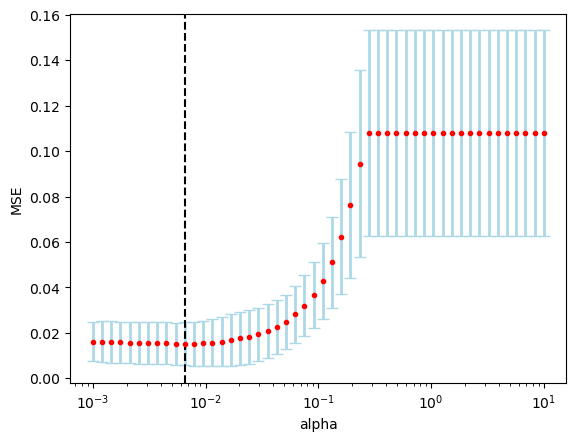

In [9]:
import matplotlib.pyplot as plt

MSEs = model_lassoCV.mse_path_

MSEs_mean = np.apply_along_axis(np.mean,1,MSEs)
MSEs_std = np.apply_along_axis(np.std,1,MSEs)

'''MSEs_mean = []
MSEs_std = []
for i in range (len(MSEs)):
    MSEs_mean.append(MSEs[i].mean())
    MSEs_std.append(MSEs[i].std)'''

plt.figure()
plt.errorbar(model_lassoCV.alphas_,MSEs_mean
            ,yerr=MSEs_std
            ,fmt='o'
            ,ms=3
            ,mfc='r'
            ,mec='r'
            ,ecolor='lightblue'
            ,elinewidth=2
            ,capsize=4
            ,capthick=1)
plt.semilogx()
plt.axvline(model_lassoCV.alpha_,color='black',ls='--')
plt.xlabel('alpha')
plt.ylabel('MSE')
ax=plt.gca()
plt.show

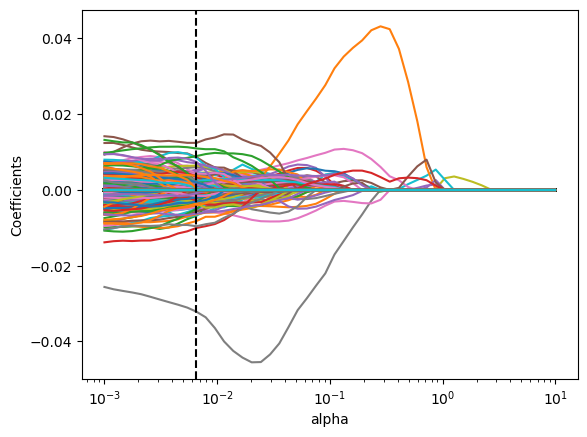

In [10]:
coefs = model_lassoCV.path(X,y,alphas = alphas,max_iter=1000)[1].T
plt.figure()
plt.semilogx(model_lassoCV.alphas_,coefs,'-')
plt.axvline(model_lassoCV.alpha_,color='black',ls='--')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.show()            

In [11]:
#x_lasso.to_csv('x_lasso.csv',index=False)

为了方便后续操作，将筛选后的数据导出

### lasso筛选后，保留了178个属性

先用决策树简单对比一下效果

In [12]:
test = pd.read_csv('x_lasso.csv')

from sklearn import tree
y = data['TYPE'].replace(['HCC','Adjacent'],[0,1])  
x_lasso = test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_lasso, y, test_size=0.25, random_state=1)

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
clf = clf.fit(x_train,y_train)
predY = clf.predict(x_test)

In [13]:
from sklearn.metrics import accuracy_score
print('Accuracy on test data is %.3f' % (accuracy_score(y_test, predY)))

Accuracy on test data is 0.960


<function matplotlib.pyplot.show(close=None, block=None)>

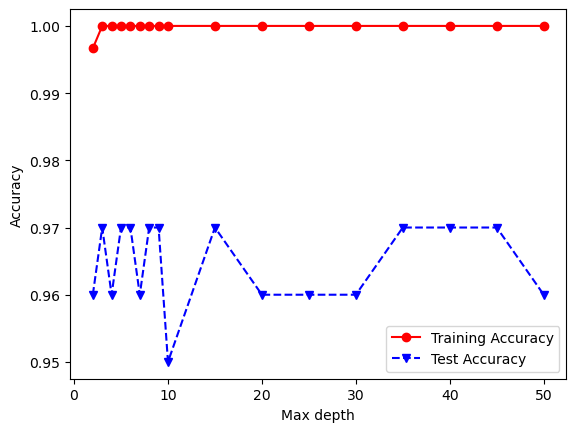

In [14]:
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))
index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(x_train,y_train)
    y_predTrain = clf.predict(x_train)
    y_predTest = clf.predict(x_test)
    trainAcc[index] = accuracy_score(y_train, y_predTrain)
    testAcc[index] = accuracy_score(y_test, y_predTest)
    index += 1
plt.plot(maxdepths,trainAcc,'ro-',maxdepths,testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show

这是使用lasso数据

In [15]:
x.head()

,A1BG,A2M,NAT1,NAT2,SERPINA3,AADAC,AAMP,AANAT,AARS,ABAT,...,LOC100289341,ZNF605,NHEG1,LOC100302401,LOC100302640,LOC100302650,NCRNA00182,TMED7-TICAM2,TSNAX-DISC1,LOC100303728
0,0.372644,0.346363,-0.438476,0.135012,0.382519,-0.465768,-2.300124,-0.602997,-3.248127,-0.588361,...,0.160291,-0.717382,6.698860,-0.541354,-0.946043,0.942725,-0.384136,-0.664411,-0.412758,0.532258
1,-2.706728,-2.275873,-1.542390,-1.482913,-2.084553,-0.648485,-0.723723,-0.602997,-1.152813,-1.130311,...,-0.330980,1.546400,2.276381,-0.474866,0.594061,-1.106231,-0.064927,0.625753,1.727762,-0.032642
2,-0.866184,0.427225,-0.079939,-0.359354,-0.671280,-0.174408,-2.145068,1.798425,-1.135496,-0.835249,...,-0.592992,1.546400,-0.173911,0.854902,-0.084045,-1.270148,0.190440,0.159990,-0.412758,-0.704126
3,0.014269,1.362913,-0.032764,0.311571,-0.356125,-0.174408,-0.284398,-0.602997,-0.564047,-1.112246,...,0.389551,1.502012,-0.173911,0.190018,0.065368,-0.756046,-1.763119,0.206566,-0.412758,-1.844583
4,-0.839638,-0.704842,0.995670,0.285890,-0.572794,-0.016383,-0.827094,-0.602997,-0.996963,0.874902,...,-1.040595,1.250481,-0.173911,0.123530,-0.946043,-1.553276,-1.265153,-0.245224,-0.412758,0.446990


In [16]:
from sklearn import tree
y = data['TYPE'].replace(['HCC','Adjacent'],[0,1])  

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=6)
clf = clf.fit(x_train,y_train)
predY = clf.predict(x_test)

In [17]:
from sklearn.metrics import accuracy_score
print('Accuracy on test data is %.3f' % (accuracy_score(y_test, predY)))

Accuracy on test data is 0.970


这是原始数据，对于决策树来说，原始数据准确率更高且速度也可以接受

<function matplotlib.pyplot.show(close=None, block=None)>

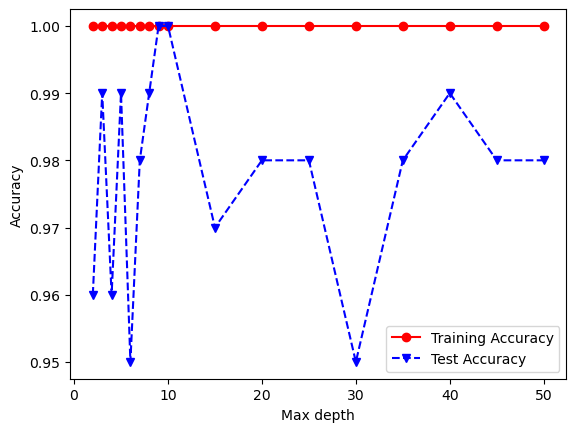

In [18]:
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))
index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(x_train,y_train)
    y_predTrain = clf.predict(x_train)
    y_predTest = clf.predict(x_test)
    trainAcc[index] = accuracy_score(y_train, y_predTrain)
    testAcc[index] = accuracy_score(y_test, y_predTest)
    index += 1
plt.plot(maxdepths,trainAcc,'ro-',maxdepths,testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.show